In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_precip = session.query(Measurement.date).\
        order_by(Measurement.date.desc()).first()

last_precip

('2017-08-23')

In [41]:
# Calculate the date 1 year ago from the last data point in the database
lastyear = dt.date(2017,8,23) - dt.timedelta(days=365)

lastyear

datetime.date(2016, 8, 23)

In [42]:
# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
         filter(Measurement.date >= lastyear).\
         order_by(Measurement.date).all()

precip[:5]

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02)]

In [43]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns = ["Date", "Precipitation"])
precip_df.set_index("Date", inplace=True)
precip_df.head(3)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05


In [44]:
# Sort the dataframe by date
precip_df.sort_index()
precip_df.head(3)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05


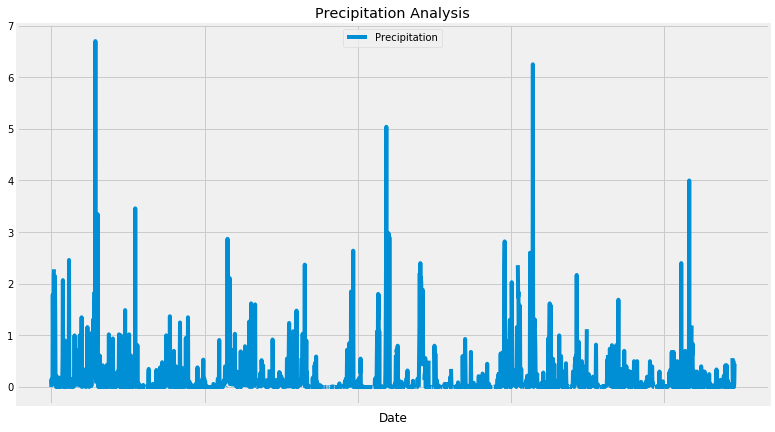

In [45]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title ="Precipitation Analysis", figsize=(12,7))
plt.legend(loc = "upper center")
plt.savefig("precip_plot.png")
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [47]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.name).count()
station_count

9

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
act_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
                                              
act_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
act_stations[0][0]

'USC00519281'

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
selections = [func.min(Measurement.tobs), 
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)]

temps = session.query(*selections).\
        filter(Measurement.station == act_stations[0][0]).all()

temps


[(54.0, 85.0, 71.66378066378067)]

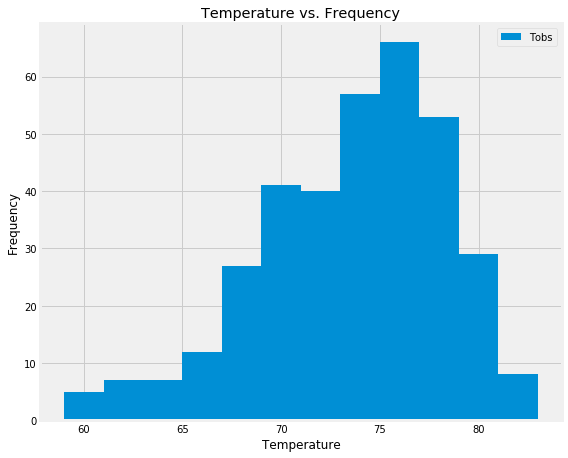

In [51]:
# Choose the station with the highest number of temperature observations.
temp_data = session.query(Measurement.tobs, Measurement.date).filter(Measurement.date >= lastyear).\
            filter(Measurement.station == act_stations[0][0]).order_by(Measurement.date).all()

temp_df = pd.DataFrame(temp_data, columns=["Tobs", "Date"])
temp_df.head()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_df.plot.hist(bins=12, figsize=(8,6))
plt.tight_layout()
plt.title("Temperature vs. Frequency")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.savefig("temp_vs_freq.png", bbox_inches = 'tight')
plt.show()

![precipitation](Images/station-histogram.png)

In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation = calc_temps("2016-09-14", "2016-09-21")
vacation

vacation_df = pd.DataFrame(vacation, columns=["TMIN", "TAVE", "TMAX"])
vacation_df

,TMIN,TAVE,TMAX
0,70.0,77.137255,81.0


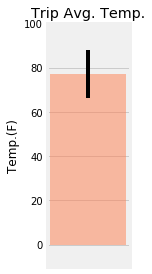

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr = vacation_df["TMAX"] - vacation_df["TMIN"]

plt.figure(figsize=(2,4))
plt.bar(1, vacation_df["TAVE"], yerr=yerr, alpha=0.5, color="coral")
plt.xticks([])
plt.yticks(np.arange(0,120,20))
plt.ylabel("Temp.(F)")
plt.title("Trip Avg. Temp.")
plt.tight_layout()
plt.ylim(-10,100)

plt.savefig("vacation_temp_plot.png", bbox_inches = 'tight')
plt.show()


In [61]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_precip = session.query(
                   Station.station, 
                   Station.name, 
                   Station.latitude, 
                   Station.longitude, 
                   Station.elevation, 
                   func.avg(Measurement.prcp)
                    ).\
                    filter(Measurement.station == Station.station, 
                    Measurement.date.between("2017-05-01", "2017-05-10")).\
                    group_by(Station.station).\
                    order_by(func.avg(Measurement.prcp).desc()).all()

print(station_precip)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.28375000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.268), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.21555555555555556), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.207), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.081), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02888888888888889)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


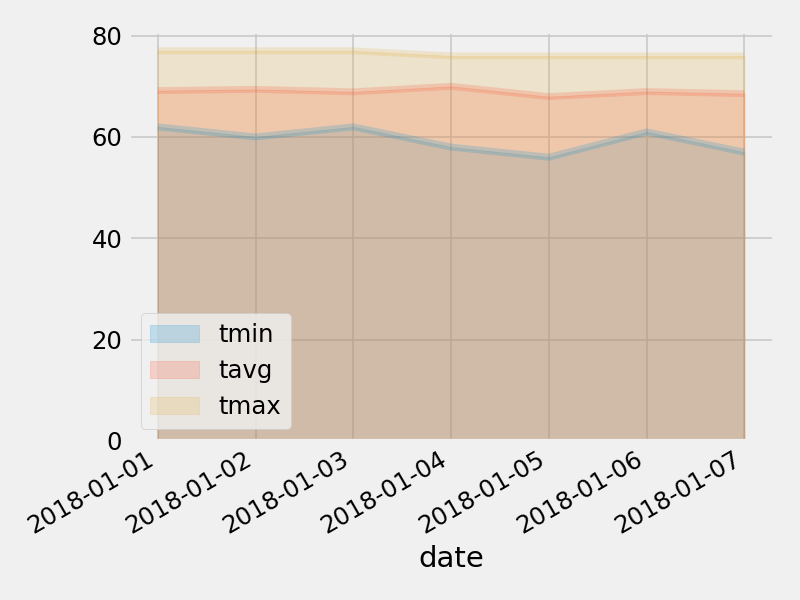

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
